# Step1. 데이터 확인

In [1]:
import os

data_path = 'cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


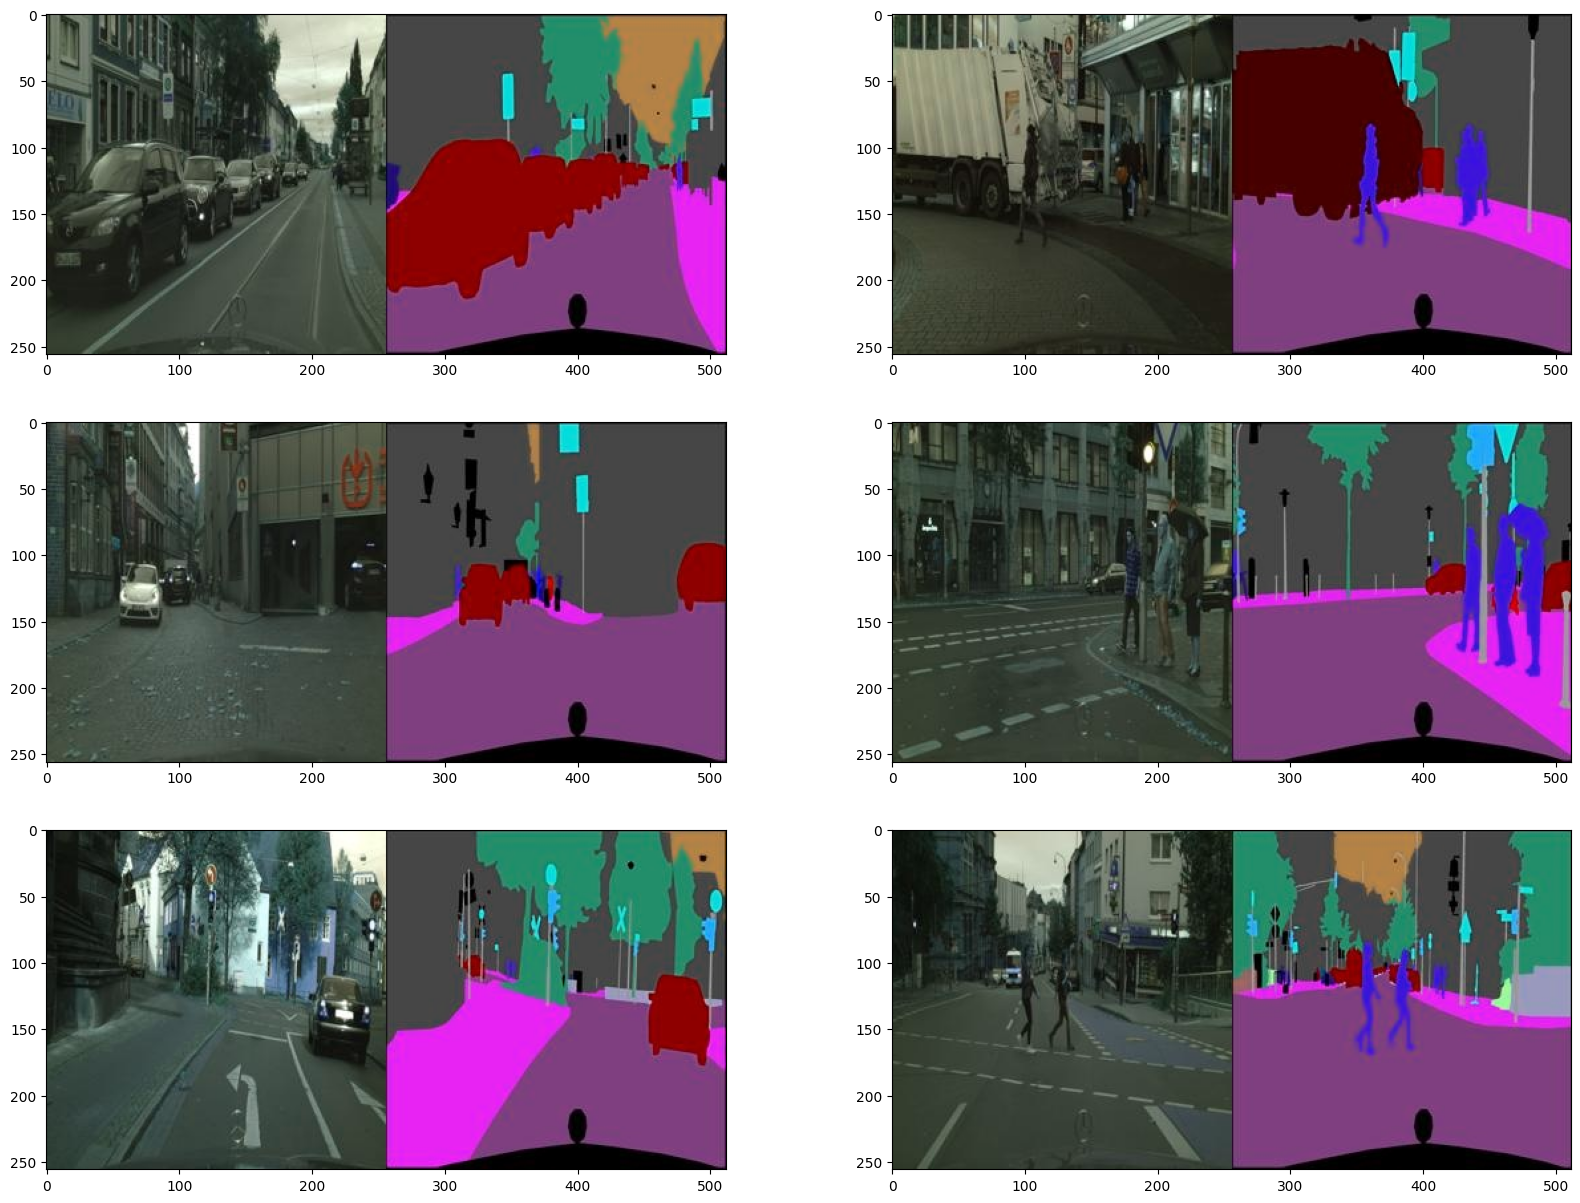

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# train data 중 6개만 랜덤하게 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


# Step2. Augmentation

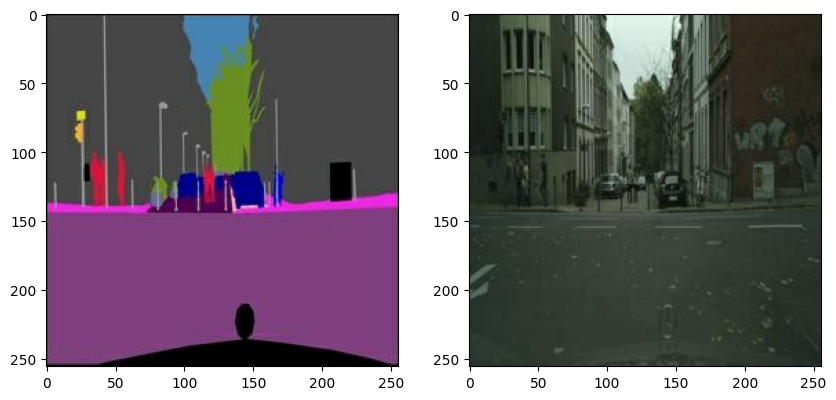

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# seg image와 real img 나눠주기
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :]
    colored = tf.cast(colored, tf.float32)
    seg = img[:, w:, :]
    seg = tf.cast(seg, tf.float32)
    return normalize(seg), normalize(colored)

f = data_path + os.listdir(data_path)[1]
seg_img, real_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(seg_img,real_img):
    stacked = tf.concat([seg_img,real_img], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, 'REFLECT')
    else:
        padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values=1.)
        
    out = image.random_crop(padded, size=[256,256,6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

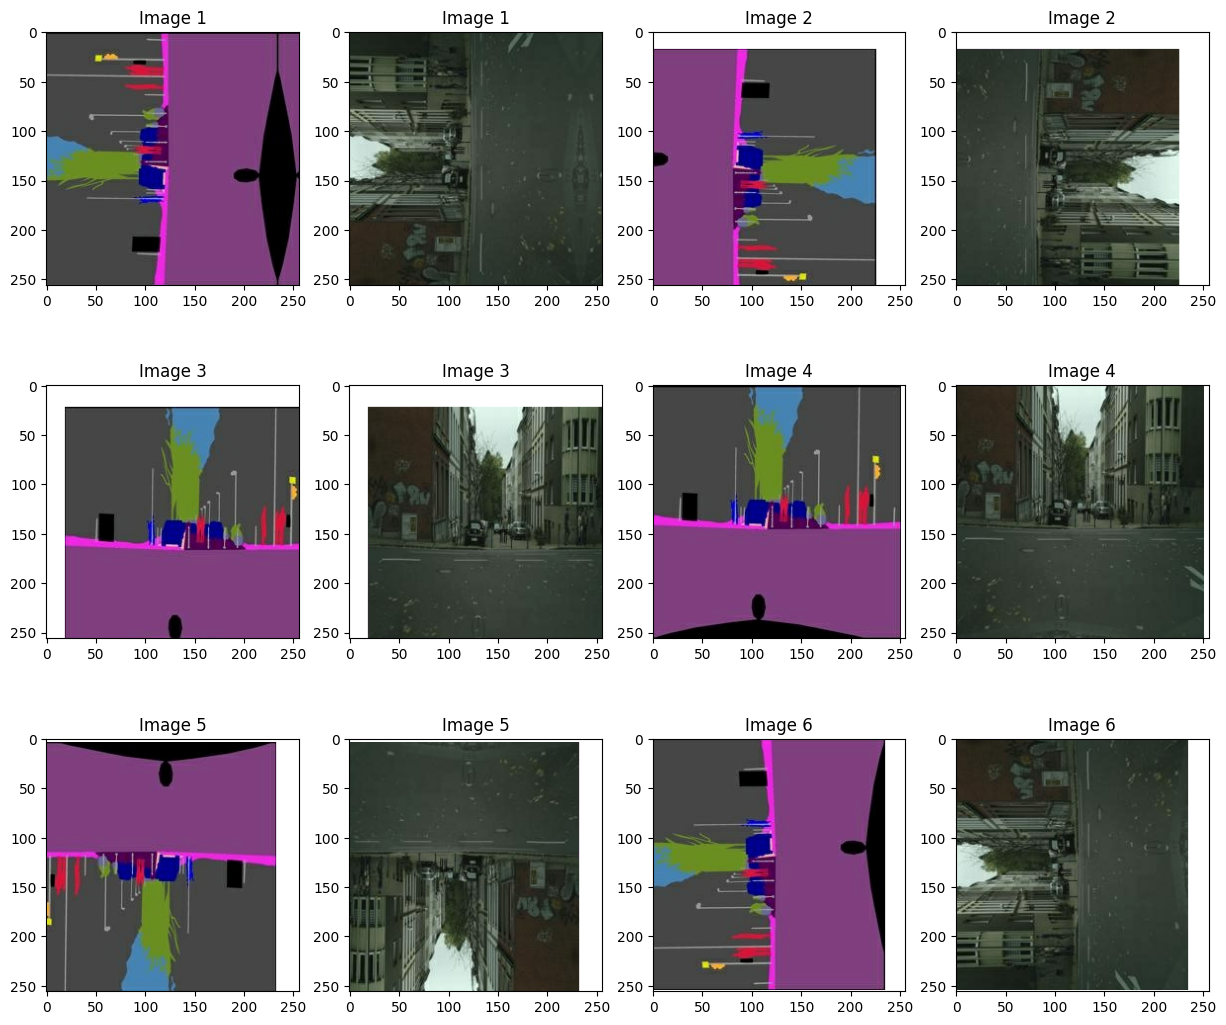

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_real = apply_augmentation(seg_img, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

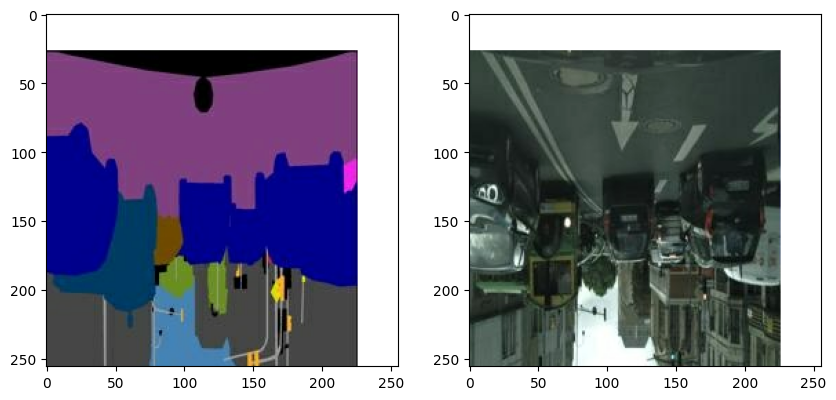

In [7]:
from tensorflow import data

# 모든 데이터set에 적용
def get_train(img_path):
    seg_img, real_img = load_img(img_path)
    seg_img, real_img = apply_augmentation(seg_img, real_img)
    return seg_img, real_img

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg_img, real_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))

# Step3. Generator구성

In [8]:
from tensorflow.keras import layers, Input, Model

# 블록 구성
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
# U-Net
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator,self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

# Step4. Discriminator 구성

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid",use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [13]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

# Step5. 학습 및 테스트

In [14]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits = False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc),real_disc)

In [15]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2 =.999)

In [16]:
@tf.function
def train_step(seg_img, real_img):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_img = generator(seg_img, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg_img, fake_img, training=True)
        real_disc = discriminator(seg_img, real_img, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_img, real_img, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [17]:
EPOCHS = 30

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")


EPOCH[1] - STEP[10]                     
Generator_loss:1.0085                     
L1_loss:0.3248                     
Discriminator_loss:1.3290

EPOCH[1] - STEP[20]                     
Generator_loss:0.7442                     
L1_loss:0.2466                     
Discriminator_loss:1.3149

EPOCH[1] - STEP[30]                     
Generator_loss:0.8287                     
L1_loss:0.2341                     
Discriminator_loss:1.2019

EPOCH[1] - STEP[40]                     
Generator_loss:0.9472                     
L1_loss:0.2080                     
Discriminator_loss:1.2121

EPOCH[1] - STEP[50]                     
Generator_loss:0.8737                     
L1_loss:0.2430                     
Discriminator_loss:1.1814

EPOCH[1] - STEP[60]                     
Generator_loss:0.6555                     
L1_loss:0.2250                     
Discriminator_loss:1.2339

EPOCH[1] - STEP[70]                     
Generator_loss:1.2448                     
L1_loss:0.2143                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.1981                     
L1_loss:0.1913                     
Discriminator_loss:0.6129

EPOCH[3] - STEP[80]                     
Generator_loss:1.0648                     
L1_loss:0.1731                     
Discriminator_loss:1.6961

EPOCH[3] - STEP[90]                     
Generator_loss:2.2639                     
L1_loss:0.1853                     
Discriminator_loss:1.3081

EPOCH[3] - STEP[100]                     
Generator_loss:1.5253                     
L1_loss:0.1598                     
Discriminator_loss:0.7494

EPOCH[3] - STEP[110]                     
Generator_loss:1.3244                     
L1_loss:0.1785                     
Discriminator_loss:0.5105

EPOCH[3] - STEP[120]                     
Generator_loss:2.0300                     
L1_loss:0.1831                     
Discriminator_loss:0.3427

EPOCH[3] - STEP[130]                     
Generator_loss:1.4574                     
L1_loss:0.1847                

EPOCH[5] - STEP[130]                     
Generator_loss:1.9207                     
L1_loss:0.1970                     
Discriminator_loss:0.4824

EPOCH[5] - STEP[140]                     
Generator_loss:1.5751                     
L1_loss:0.1863                     
Discriminator_loss:1.1823

EPOCH[5] - STEP[150]                     
Generator_loss:2.5987                     
L1_loss:0.1695                     
Discriminator_loss:0.2204

EPOCH[5] - STEP[160]                     
Generator_loss:0.9042                     
L1_loss:0.1850                     
Discriminator_loss:1.6655

EPOCH[5] - STEP[170]                     
Generator_loss:1.3366                     
L1_loss:0.2114                     
Discriminator_loss:0.6026

EPOCH[5] - STEP[180]                     
Generator_loss:1.1180                     
L1_loss:0.1595                     
Discriminator_loss:0.9967

EPOCH[5] - STEP[190]                     
Generator_loss:1.2252                     
L1_loss:0.1666             

EPOCH[7] - STEP[190]                     
Generator_loss:0.4144                     
L1_loss:0.1908                     
Discriminator_loss:1.3023

EPOCH[7] - STEP[200]                     
Generator_loss:1.3322                     
L1_loss:0.1731                     
Discriminator_loss:0.6210

EPOCH[7] - STEP[210]                     
Generator_loss:1.1212                     
L1_loss:0.1897                     
Discriminator_loss:0.7104

EPOCH[7] - STEP[220]                     
Generator_loss:1.9069                     
L1_loss:0.2205                     
Discriminator_loss:0.5700

EPOCH[7] - STEP[230]                     
Generator_loss:1.8119                     
L1_loss:0.2028                     
Discriminator_loss:0.6597

EPOCH[7] - STEP[240]                     
Generator_loss:2.0786                     
L1_loss:0.1830                     
Discriminator_loss:0.2475

EPOCH[7] - STEP[250]                     
Generator_loss:1.7312                     
L1_loss:0.1647             

EPOCH[9] - STEP[250]                     
Generator_loss:0.6331                     
L1_loss:0.1716                     
Discriminator_loss:1.0475

EPOCH[10] - STEP[10]                     
Generator_loss:1.5543                     
L1_loss:0.2120                     
Discriminator_loss:0.3292

EPOCH[10] - STEP[20]                     
Generator_loss:0.9604                     
L1_loss:0.1804                     
Discriminator_loss:0.7252

EPOCH[10] - STEP[30]                     
Generator_loss:0.7370                     
L1_loss:0.1786                     
Discriminator_loss:1.0298

EPOCH[10] - STEP[40]                     
Generator_loss:0.3381                     
L1_loss:0.1785                     
Discriminator_loss:1.5001

EPOCH[10] - STEP[50]                     
Generator_loss:1.3095                     
L1_loss:0.1580                     
Discriminator_loss:1.1383

EPOCH[10] - STEP[60]                     
Generator_loss:1.1727                     
L1_loss:0.1726             

EPOCH[12] - STEP[60]                     
Generator_loss:1.1836                     
L1_loss:0.1635                     
Discriminator_loss:0.8281

EPOCH[12] - STEP[70]                     
Generator_loss:0.9716                     
L1_loss:0.1717                     
Discriminator_loss:1.0795

EPOCH[12] - STEP[80]                     
Generator_loss:0.4406                     
L1_loss:0.1961                     
Discriminator_loss:1.2427

EPOCH[12] - STEP[90]                     
Generator_loss:0.9899                     
L1_loss:0.1724                     
Discriminator_loss:0.7822

EPOCH[12] - STEP[100]                     
Generator_loss:2.2762                     
L1_loss:0.1890                     
Discriminator_loss:0.1933

EPOCH[12] - STEP[110]                     
Generator_loss:1.5699                     
L1_loss:0.2072                     
Discriminator_loss:0.2771

EPOCH[12] - STEP[120]                     
Generator_loss:2.3842                     
L1_loss:0.1654          

EPOCH[14] - STEP[120]                     
Generator_loss:1.7210                     
L1_loss:0.1630                     
Discriminator_loss:1.2904

EPOCH[14] - STEP[130]                     
Generator_loss:1.1557                     
L1_loss:0.1913                     
Discriminator_loss:2.2433

EPOCH[14] - STEP[140]                     
Generator_loss:1.5997                     
L1_loss:0.1776                     
Discriminator_loss:0.3804

EPOCH[14] - STEP[150]                     
Generator_loss:1.7051                     
L1_loss:0.1661                     
Discriminator_loss:0.8281

EPOCH[14] - STEP[160]                     
Generator_loss:0.3593                     
L1_loss:0.2061                     
Discriminator_loss:2.0993

EPOCH[14] - STEP[170]                     
Generator_loss:0.8321                     
L1_loss:0.1859                     
Discriminator_loss:0.6832

EPOCH[14] - STEP[180]                     
Generator_loss:1.3252                     
L1_loss:0.1516      

EPOCH[16] - STEP[180]                     
Generator_loss:2.6731                     
L1_loss:0.1895                     
Discriminator_loss:0.2328

EPOCH[16] - STEP[190]                     
Generator_loss:3.0765                     
L1_loss:0.1892                     
Discriminator_loss:0.2374

EPOCH[16] - STEP[200]                     
Generator_loss:0.7622                     
L1_loss:0.1612                     
Discriminator_loss:0.9072

EPOCH[16] - STEP[210]                     
Generator_loss:1.0803                     
L1_loss:0.1795                     
Discriminator_loss:0.5739

EPOCH[16] - STEP[220]                     
Generator_loss:1.8235                     
L1_loss:0.1929                     
Discriminator_loss:0.6596

EPOCH[16] - STEP[230]                     
Generator_loss:1.0207                     
L1_loss:0.1769                     
Discriminator_loss:0.6380

EPOCH[16] - STEP[240]                     
Generator_loss:2.5159                     
L1_loss:0.1802      

EPOCH[18] - STEP[240]                     
Generator_loss:1.2379                     
L1_loss:0.1392                     
Discriminator_loss:0.7664

EPOCH[18] - STEP[250]                     
Generator_loss:1.8467                     
L1_loss:0.1719                     
Discriminator_loss:0.6150

EPOCH[19] - STEP[10]                     
Generator_loss:0.3030                     
L1_loss:0.1734                     
Discriminator_loss:1.6573

EPOCH[19] - STEP[20]                     
Generator_loss:1.0649                     
L1_loss:0.1602                     
Discriminator_loss:0.9475

EPOCH[19] - STEP[30]                     
Generator_loss:0.9641                     
L1_loss:0.1884                     
Discriminator_loss:2.2876

EPOCH[19] - STEP[40]                     
Generator_loss:1.8876                     
L1_loss:0.1779                     
Discriminator_loss:0.5016

EPOCH[19] - STEP[50]                     
Generator_loss:1.7785                     
L1_loss:0.1762           

EPOCH[21] - STEP[50]                     
Generator_loss:0.9457                     
L1_loss:0.1647                     
Discriminator_loss:0.8640

EPOCH[21] - STEP[60]                     
Generator_loss:0.7692                     
L1_loss:0.1530                     
Discriminator_loss:1.2400

EPOCH[21] - STEP[70]                     
Generator_loss:0.8579                     
L1_loss:0.1705                     
Discriminator_loss:0.7701

EPOCH[21] - STEP[80]                     
Generator_loss:1.7753                     
L1_loss:0.1504                     
Discriminator_loss:1.3001

EPOCH[21] - STEP[90]                     
Generator_loss:1.8338                     
L1_loss:0.2057                     
Discriminator_loss:0.5518

EPOCH[21] - STEP[100]                     
Generator_loss:2.3802                     
L1_loss:0.1822                     
Discriminator_loss:0.8005

EPOCH[21] - STEP[110]                     
Generator_loss:2.0620                     
L1_loss:0.2044           

EPOCH[23] - STEP[110]                     
Generator_loss:0.9461                     
L1_loss:0.2011                     
Discriminator_loss:0.5680

EPOCH[23] - STEP[120]                     
Generator_loss:0.7790                     
L1_loss:0.1482                     
Discriminator_loss:1.8296

EPOCH[23] - STEP[130]                     
Generator_loss:0.6812                     
L1_loss:0.1415                     
Discriminator_loss:1.0328

EPOCH[23] - STEP[140]                     
Generator_loss:1.7795                     
L1_loss:0.1838                     
Discriminator_loss:0.6406

EPOCH[23] - STEP[150]                     
Generator_loss:0.9091                     
L1_loss:0.1696                     
Discriminator_loss:1.4718

EPOCH[23] - STEP[160]                     
Generator_loss:2.3774                     
L1_loss:0.1794                     
Discriminator_loss:0.6762

EPOCH[23] - STEP[170]                     
Generator_loss:1.8124                     
L1_loss:0.1884      

EPOCH[25] - STEP[170]                     
Generator_loss:0.4739                     
L1_loss:0.2003                     
Discriminator_loss:1.2229

EPOCH[25] - STEP[180]                     
Generator_loss:1.7088                     
L1_loss:0.1591                     
Discriminator_loss:0.6940

EPOCH[25] - STEP[190]                     
Generator_loss:1.6561                     
L1_loss:0.1649                     
Discriminator_loss:1.5362

EPOCH[25] - STEP[200]                     
Generator_loss:0.5897                     
L1_loss:0.1723                     
Discriminator_loss:1.6669

EPOCH[25] - STEP[210]                     
Generator_loss:1.0992                     
L1_loss:0.1916                     
Discriminator_loss:0.7810

EPOCH[25] - STEP[220]                     
Generator_loss:1.5405                     
L1_loss:0.1810                     
Discriminator_loss:1.3286

EPOCH[25] - STEP[230]                     
Generator_loss:2.1283                     
L1_loss:0.1791      

EPOCH[27] - STEP[230]                     
Generator_loss:1.6354                     
L1_loss:0.1763                     
Discriminator_loss:0.4461

EPOCH[27] - STEP[240]                     
Generator_loss:1.2708                     
L1_loss:0.1686                     
Discriminator_loss:1.9520

EPOCH[27] - STEP[250]                     
Generator_loss:1.2887                     
L1_loss:0.1855                     
Discriminator_loss:0.5012

EPOCH[28] - STEP[10]                     
Generator_loss:1.7313                     
L1_loss:0.1563                     
Discriminator_loss:0.7931

EPOCH[28] - STEP[20]                     
Generator_loss:1.3733                     
L1_loss:0.1917                     
Discriminator_loss:0.8556

EPOCH[28] - STEP[30]                     
Generator_loss:1.5741                     
L1_loss:0.1724                     
Discriminator_loss:0.6216

EPOCH[28] - STEP[40]                     
Generator_loss:0.7785                     
L1_loss:0.1961          

EPOCH[30] - STEP[40]                     
Generator_loss:0.3766                     
L1_loss:0.2215                     
Discriminator_loss:1.3178

EPOCH[30] - STEP[50]                     
Generator_loss:1.6519                     
L1_loss:0.1983                     
Discriminator_loss:1.6982

EPOCH[30] - STEP[60]                     
Generator_loss:1.5782                     
L1_loss:0.1663                     
Discriminator_loss:0.7228

EPOCH[30] - STEP[70]                     
Generator_loss:1.5607                     
L1_loss:0.2133                     
Discriminator_loss:0.4488

EPOCH[30] - STEP[80]                     
Generator_loss:1.4615                     
L1_loss:0.1731                     
Discriminator_loss:0.8454

EPOCH[30] - STEP[90]                     
Generator_loss:0.7648                     
L1_loss:0.1587                     
Discriminator_loss:0.9013

EPOCH[30] - STEP[100]                     
Generator_loss:1.8856                     
L1_loss:0.1602            

Text(0.5, 1.0, 'real')

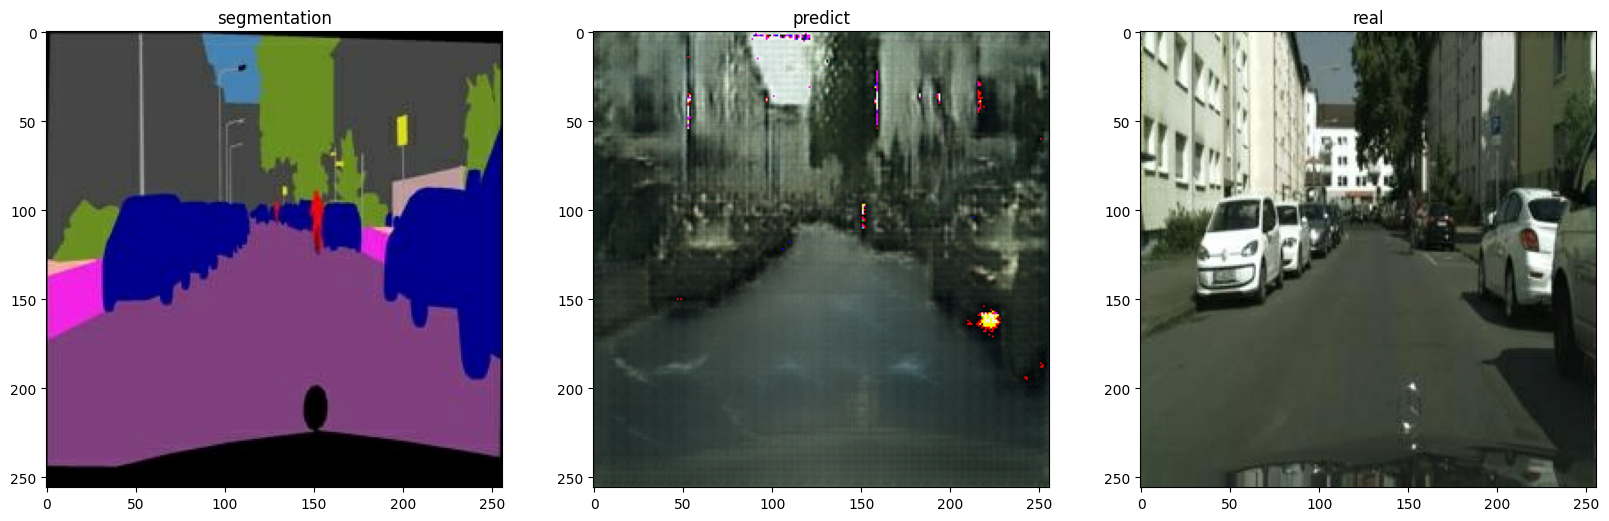

In [18]:
test_ind = 1

val_data_path = 'cityscapes/val/'
f = val_data_path + os.listdir(val_data_path)[test_ind]
seg_img, real_img = load_img(f)

pred = generator(tf.expand_dims(seg_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg_img)); plt.title('segmentation')
plt.subplot(1,3,2); plt.imshow(pred[0]);plt.title('predict')
plt.subplot(1,3,3); plt.imshow(denormalize(real_img));plt.title('real')

# 회고

- crop, flip진행 
- generator에 U-Net 적용
- descriminator 마지막 출력은 (30,30,1)
- batch size 4로 250번씩 진행

epoch 15번일 때 사진
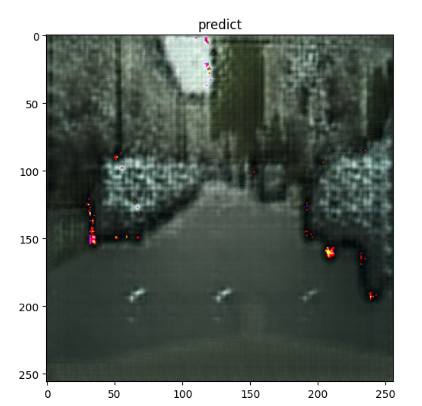

epoch한번에 4개씩 250번 진행하기 때문에 시간이 조금 많이 오래걸리긴 하지만\
위 사진을 보면 알 수 있듯이 학습 횟수를 올릴수록 형체가 더 잘 보이긴했습니다.\
결과적으로 흐릿하지만 real image에서 보이는 물체들의 형태는 볼 수 있게 됐습니다.